In [1]:
import numpy as np
import os
import cupy as cp
import time
import gc
import ksig
import tracemalloc
import threading
import pynvml

# Ensure we use GPU-0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

EMBEDDING_ORDER = 1
N = 10
d = 5

M = 5
n_components_rff = 100
n_components_proj = 100

In [2]:
def rfsf_trp(X, n_levels, n_components_rff, n_components_proj, **kwargs):
    static_features = ksig.static.features.RandomFourierFeatures(n_components=n_components_rff)
    projection = ksig.projections.TensorizedRandomProjection(n_components=n_components_proj)

    FM = ksig.kernels.SignatureFeatures(
        n_levels=n_levels, order=EMBEDDING_ORDER,
        static_features=static_features,
        projection=projection,
    )
    FM.fit(X)

    return FM


def rfsf_dp2(X, n_levels, n_components_rff, n_components_proj, **kwargs):
    static_features = ksig.static.features.RandomFourierFeatures(n_components=n_components_rff)
    projection = ksig.projections.DiagonalProjection(internal_size=2)

    FM = ksig.kernels.SignatureFeatures(
        n_levels=n_levels, order=EMBEDDING_ORDER,
        static_features=static_features,
        projection=projection,
    )
    FM.fit(X)

    return FM


def rfsf_dp1(X, n_levels, n_components_rff, n_components_proj, **kwargs):
    static_features = ksig.static.features.RandomFourierFeatures1D(n_components=n_components_rff)
    projection = ksig.projections.DiagonalProjection(internal_size=1)

    FM = ksig.kernels.SignatureFeatures(
        n_levels=n_levels, order=EMBEDDING_ORDER,
        static_features=static_features,
        projection=projection,
    )
    FM.fit(X)

    return FM


def rfsf_cs(X, n_levels, n_components_rff, n_components_proj, **kwargs):
    static_features = ksig.static.features.RandomFourierFeatures(n_components=n_components_rff)
    projection = ksig.projections.CountSketchRandomProjection(n_components=n_components_proj)

    FM = ksig.kernels.SignatureFeatures(
        n_levels=n_levels, order=EMBEDDING_ORDER,
        static_features=static_features,
        projection=projection,
    )
    FM.fit(X)

    return FM

def lifted_kt(X, n_levels, **kwargs):
    static_kernel = ksig.static.kernels.RBFKernel()

    Ksig = ksig.kernels.SignatureKernel(
        n_levels=n_levels, order=EMBEDDING_ORDER,
        static_kernel=static_kernel
    )

    return Ksig


def lifted_pde(X, **kwargs):
    static_kernel = ksig.static.kernels.RBFKernel()

    Ksig = ksig.kernels.SignaturePDEKernel(
        static_kernel=static_kernel
    )

    return Ksig

In [3]:
L = 100
N=100
# Generate X, Y
cp.random.seed(123)
X = cp.random.randn(N, L, d)
X = cp.cumsum(X, axis=1) / cp.sqrt(L)

M = 10
n = 1000

In [4]:
exact_kernel = lifted_kt(X, n_levels=M)

exact_levels = exact_kernel._compute_kernel(X)

np.diagonal(exact_levels, axis1=1, axis2=2)

diag = np.diagonal(exact_levels, axis1=1, axis2=2)
normalised_levels = exact_levels / np.sqrt(diag[:, :, None] * diag[:, None, :])

In [5]:
from ksig.algorithms import signature_kern_low_rank
import ksig.utils as utils
from ksig.utils import _EPS

In [6]:
kernel = rfsf_trp(X, M, n, n)


In [7]:
from math import ceil

In [8]:
rmses = dict()
mapes = dict()

In [9]:
for name, function in zip(
    [
    "rfsf_trp", "rfsf_dp2", "rfsf_dp1",
    "rfsf_cs",
    ],
    [
    rfsf_trp, rfsf_dp2, rfsf_dp1,
        rfsf_cs
    ]
):

    n = 1000
    if name == "rfsf_dp2":
        n = ceil(n * M / (2**(M+1) - 1))
    
    kernel = function(X, M, n, n)

    self = kernel
    if self.static_features is not None:
      # Merge batch and sequence axes.
      seq_shape = X.shape[:-1] + (-1,)
      X_ = X.reshape([-1, X.shape[-1]])
      if isinstance(self.static_features_, list):
        U = [self.static_features_[i].transform(X_, return_on_gpu=True).reshape(
          seq_shape) for i in range(self.n_levels)]
      else:
        U = (self.static_features_.transform(X_, return_on_gpu=True).reshape(
          seq_shape) if self.static_features is not None else X)
    else:
      U = X
    
    P = signature_kern_low_rank(
      U, self.n_levels, order=self.order, difference=self.difference,
      return_levels=True, projections=self.projections_)
    
    P_norms = [cp.maximum(
    utils.robust_sqrt(utils.squared_norm(p, axis=-1)), _EPS) for p in P]
    P = [p / P_norms[i][..., None] for i, p in enumerate(P)]

    print(name)
    print([p.shape for p in P])
    
    kernel_rmses = []
    kernel_mapes = []
    for m in range(5+1):
        k_m = P[m] @ P[m].T
        k_m_exact = normalised_levels[m]
        num_entries = N * (N-1) // 2
    
        error = cp.triu(k_m_exact - k_m, k=1)
        rmse = cp.sqrt((error ** 2).sum() / num_entries)
    
        ratio = cp.triu(k_m / k_m_exact - 1)
        mape = cp.abs(ratio).sum() / num_entries
    
        kernel_rmses.append(rmse.item())
        kernel_mapes.append(mape.item())
    
    rmses[name] = kernel_rmses
    mapes[name] = kernel_mapes

rfsf_trp
[(100, 1), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000)]
rfsf_dp2
[(100, 1), (100, 10), (100, 20), (100, 40), (100, 80), (100, 160), (100, 320), (100, 640), (100, 1280), (100, 2560), (100, 5120)]
rfsf_dp1
[(100, 1), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000)]
rfsf_cs
[(100, 1), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000), (100, 1000)]


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

Text(0, 0.5, 'RMSE')

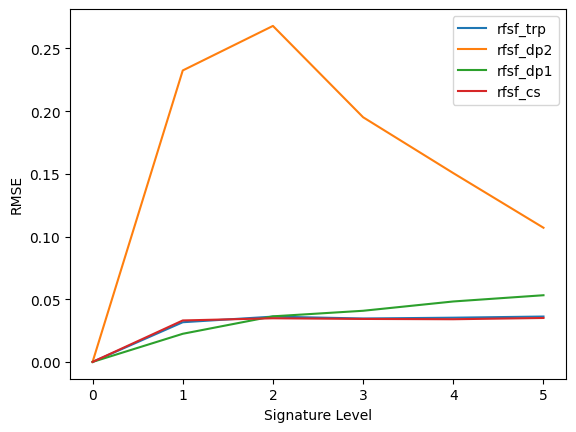

In [11]:
pd.DataFrame(rmses).plot()
plt.xlabel("Signature Level")
plt.ylabel("RMSE")

Text(0, 0.5, 'MAPE')

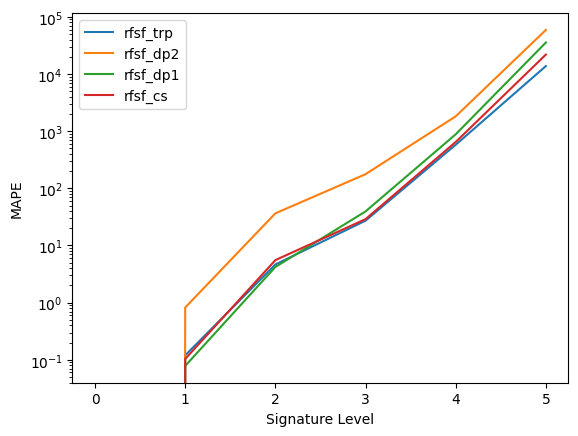

In [12]:
pd.DataFrame(mapes).plot()
plt.xlabel("Signature Level")
plt.semilogy()
plt.ylabel("MAPE")